In [256]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import pandas as pd
from tqdm.auto import notebook_tqdm as tqdm
from uncertainties import ufloat
import seaborn as sns
from joblib import delayed, Parallel
from sklearn.datasets import make_blobs

%load_ext autoreload
%autoreload 2

import tetrahedron
import proj_quality
from metric.metric import Metric, Euclid, Triangular

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
# simulate triangles
rng = np.random.default_rng()
metric = Triangular() #Euclid(2)
make_probs = True

def skew(points):
    """stretch each axis by a random factor"""
    scale = 1 + 10* rng.random(size=points.shape[-1])
    return points * scale[np.newaxis, :]

def generate_univar_points(n_samples = 1000, dim = 7, homogenious=True, seed=0):
    rng = np.random.default_rng(seed)
    points = rng.random(size=[n_samples, dim]) * 37 - 37/2
    if not homogenious:
        points = skew(points)
    return points

def generate_univar_grid_points(n_samples = 1000, dim = 7, seed=0):
    rng = np.random.default_rng(seed)
 
    points = rng.integers(low=37//2, high=37*2, size=[n_samples, dim])
    return points

def generate_gaussian_points(n_samples = 1000, dim = 7, homogenious=False, seed=0):
    rng = np.random.default_rng(seed)
 
    points = rng.standard_normal([n_samples, dim])
    if not homogenious:
        points = skew(points)
    return points

def generate_multi_cluster(n_samples=1000, dim=7, seed=0):
    std=3 # good overlap, but still differentiable
    points, labels = make_blobs(n_samples=n_samples, 
                  n_features=dim, 
                  centers=4, 
                  cluster_std=std,
                random_state=seed)
    return points

def generate_sparse_cluster(n_samples=1000, dim=7, seed=0):
    rng = np.random.default_rng(seed)
    std = 1 # almost no overlap
    points, labels = make_blobs(n_samples=n_samples, 
                  n_features=dim, 
                  centers=4, 
                  cluster_std=std,
                               random_state=seed)
    return points

generators = {
    "univariate, idd":lambda **kwargs:generate_univar_points(**kwargs, homogenious=False),
    "univariate, stretched":lambda **kwargs:generate_univar_points(**kwargs, homogenious=False),
    "gaussian, circular":lambda **kwargs:generate_gaussian_points(**kwargs, homogenious=True),
    "gaussian, eliptic":lambda  **kwargs:generate_gaussian_points(**kwargs, homogenious=False),
    "clusters, overlapping":generate_multi_cluster,
    "clusters, sparse":generate_sparse_cluster
}

In [258]:
if make_probs:
    def _make_prob(points):
        # some kind of function that generates probabilities from any values
        rv = 1 + points - points.min(axis=1).reshape(-1,1)
        rv = rv / rv.sum(axis=1).reshape(-1,1)
        return rv
    normalized_generators = {
        name : lambda **kwargs:_make_prob(gen(**kwargs))
        for name, gen in generators.items()}
    generators = normalized_generators

In [259]:
def mask_diag(a):
    diag = np.diag(np.ones(a.shape[0]))
    return np.ma.array(a, mask=diag)

def max_dist_points(ps):
    dists = metric.distance_matrix(ps,ps)
    flat_index = dists.argmax()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

def min_dist_points(ps):
    dists = metric.distance_matrix(ps,ps)
    diag = np.diag_indices(len(ps))
    dists[diag] = np.inf
    
    flat_index = dists.argmin()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

def get_most_central_points_idx(ps):
    dists = metric.distance_matrix(ps,ps)
    dists = mask_diag(dists)
    
    return np.argsort(dists.std(axis=1))

def two_most_central(ps):
    cent = get_most_central_points_idx(ps)
    return ps[cent[:2]]

def two_least_central(ps):
    cent = get_most_central_points_idx(ps)
    return ps[cent[-2:]]

def two_remote_points(ps):
    dists = metric.distance_matrix(ps,ps)
    dists = mask_diag(dists)
    remoteness = (dists**2).sum(axis=1)
    remoteness_idx = np.argsort(remoteness)
    return ps[remoteness_idx[-2:]]

def central_and_distant(ps):
    cent = get_most_central_points_idx(ps)
    p0 = ps[cent[0]]
    most_dist = np.argmax(metric(p0, ps))
    p1 = ps[most_dist]
    return p0, p1

def find_close_center(ps, cluster_member):
    dists = metric(cluster_member, ps)
    close_points = ps[dists < np.median(dists)]
    
    dists = metric.distance_matrix(close_points, close_points)
    dists = mask_diag(dists)
    
    center_idx = np.argmin(dists.std(axis=1))
    return close_points[center_idx]

def different_cluster_centers(ps):
    # a,b are likely in different clusters
    a, b = max_dist_points(ps)
    center_a = find_close_center(ps, a)
    center_b = find_close_center(ps, b)

    while np.allclose(center_a, center_b):
        # we need two distinct pivots!
        center_b = rng.choice(ps, size=1) 
    return center_a, center_b

algs = dict(
    random=lambda points:rng.choice(points, size=2, replace=False),
    maximize_dist=max_dist_points,
    # those two always perform worse 
    #minimize_dist=min_dist_points,
    #central_points=two_most_central,
    non_central_points=two_least_central,
    remoteness=two_remote_points,
    central_and_distant=central_and_distant,
    different_cluster_centers=different_cluster_centers,
)

In [260]:
def optimize_pivots(points, criterion, return_full=False):
    quality = np.nan * np.ones([len(points), len(points)],float)

    for i, p0 in enumerate(tqdm(points)):
        for j, p1 in enumerate(tqdm(points, leave=False)):
            if j<=i: continue
            try:
                points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
                quality[i,j] = criterion(points_p)
            except KeyError:
                quality[i,j] = np.nan

    
    # make symmetric
    lower_tri = np.tril_indices(quality.shape[0], -1)
    quality[lower_tri] = quality.T[lower_tri]
    
    quality = mask_diag(quality)
    
    if return_full:    
        return quality
    else:
        return np.unravel_index(np.argmax(quality), quality.shape)

In [261]:
def _hilbert_quality(points, r):
    try:
        part = proj_quality.HilbertPartitioner(points, r)
        return part.hyperplane_quality(points)
    except KeyError:
        raise
        return 0

In [262]:
index = optimize_pivots(points, _hilbert_quality, False)
p0,p1 = points[np.array(index)]
points_p_best_hq = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)

NameError: name 'points' is not defined

In [263]:
def compare_projections(point_gen:dict, pivot_selector:dict, dims:list, seed=0):
    rv = []
    for dim in tqdm(dims, leave=False):
        for gen_name, gen_func in point_gen.items():
            points = gen_func(dim=dim, seed=seed)
            r = proj_quality.get_average_k_nn_dist(points, metric, k=10)
            for algo_name, select_pivots in pivot_selector.items():
                try:
                    p0, p1 = select_pivots(points)
                    points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
                    rv.append(dict(
                        dim=dim,
                        dataset=gen_name,
                        algorithm=algo_name,
                        mean_candidate_set_size=proj_quality.candidate_set_size(points_p,r,metric),
                        hilbert_quality=_hilbert_quality(points_p,r),
                    ))
                except:
                    rv.append(dict(
                        dim=dim,
                        dataset=gen_name,
                        algorithm=algo_name,
                        mean_candidate_set_size=-1,
                        hilbert_quality=-1,
                        note="failed",
                    ))
    rv = pd.DataFrame(rv)
    return rv

In [264]:
def aggregate_runs(results):
    def to_ufloat(data):
        return ufloat(np.mean(data), np.std(data,ddof=1))
    rv = results.drop(columns="run").groupby("algorithm").agg(to_ufloat)
    return rv

In [ ]:
dims = range(2,15)
sampels = range(100)

def run(run_id):
    r = compare_projections(generators, algs, dims, seed=run_id)
    r["run"] = run_id
    return r

jobs = [delayed(run)(run_id) for run_id in sampels]
results = pd.concat(Parallel(n_jobs=20, verbose=11)(jobs))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done   3 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done   6 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:  2.3min
[Parallel(n_jobs=20)]: Done  13 tasks      | elapsed:  2.3min
[Parallel(n_jobs=20)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=20)]: Done  15 tasks      | elapsed:  

In [88]:
results

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,note,run
0,2,"univariate, idd",random,15.020,0.922,NaN,0
1,2,"univariate, idd",maximize_dist,14.392,0.909,NaN,0
2,2,"univariate, idd",minimize_dist,15.854,0.930,NaN,0
3,2,"univariate, idd",central_points,16.218,0.819,NaN,0
4,2,"univariate, idd",non_central_points,9.006,0.924,NaN,0
...,...,...,...,...,...,...,...
619,14,"clusters, sparse",central_points,335.868,0.395,NaN,99
620,14,"clusters, sparse",non_central_points,297.538,1.000,NaN,99
621,14,"clusters, sparse",remoteness,242.744,0.491,NaN,99
622,14,"clusters, sparse",central_and_distant,242.334,0.518,NaN,99


In [101]:
def _normalize(df):
    df = df[df.note != "failed"]
    random = df.query("algorithm == 'random'")
    df.hilbert_quality /= random.hilbert_quality.mean()
    df.mean_candidate_set_size /= random.mean_candidate_set_size.mean()
    return df
normalized_res = results.groupby(["dataset","dim"]).apply(_normalize)

/tmp/ipykernel_262771/3273380724.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_res = results.groupby(["dataset","dim"]).apply(_normalize)


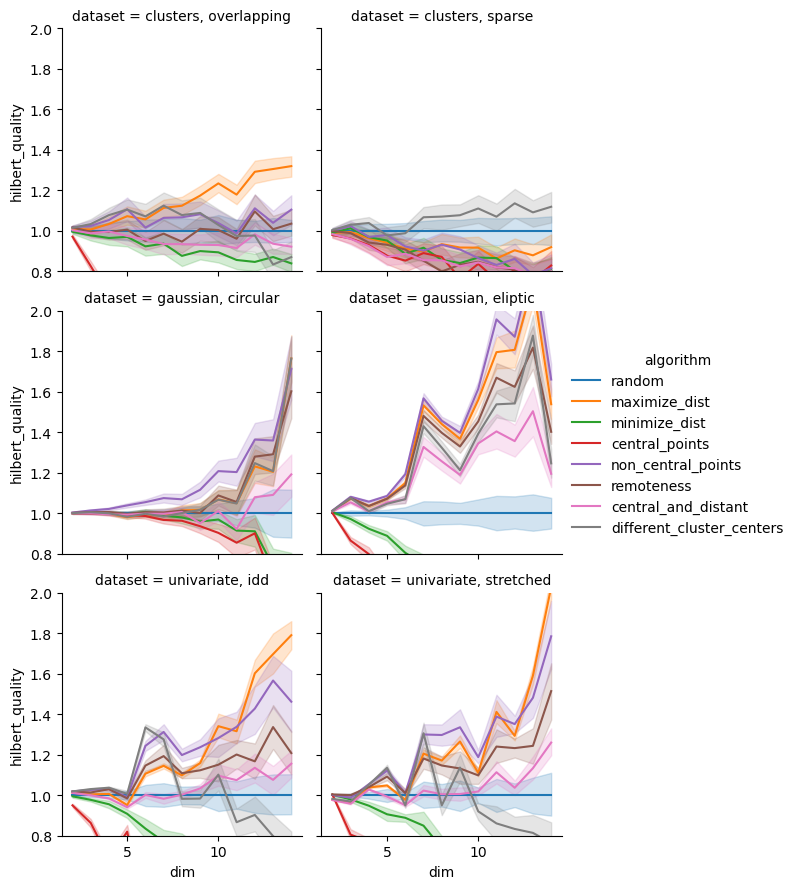

In [107]:
g = sns.FacetGrid(normalized_res, col="dataset", hue="algorithm", col_wrap=2)
g.map(sns.lineplot, "dim", "hilbert_quality").set(ylim=(0.8,2))
g.add_legend()

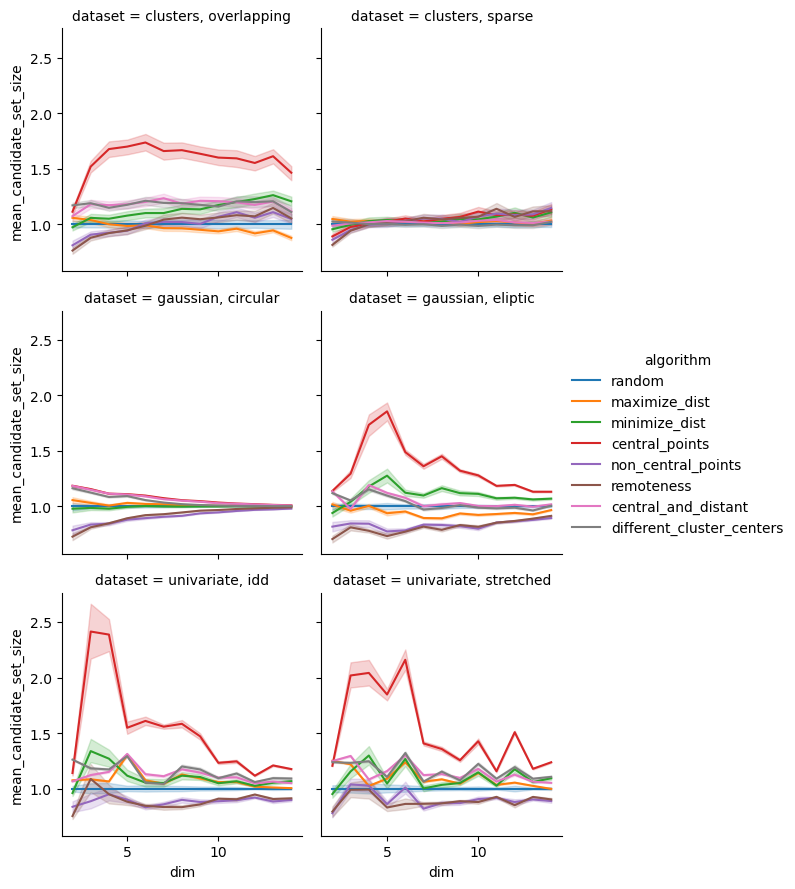

In [108]:
g = sns.FacetGrid(normalized_res, col="dataset", hue="algorithm", col_wrap=2)
g.map(sns.lineplot, "dim", "mean_candidate_set_size")
g.add_legend()

In [ ]:
sns.lineplot(results, x="dim", y="hilbert_quality", hue="algorithm")
#plt.yscale("log")

In [ ]:
def plot_hilbert_qual(ps):
    part = proj_quality.HilbertPartitioner(ps, ten_nn_dist)
    l, r = part.get_partitions(ps)

    plt.scatter(*ps.T)
    plt.scatter(*ps[l].T, marker="+", label="left partition")
    plt.scatter(*ps[r].T, marker="x", label="right partition")
    
    hq = part.hyperplane_quality(ps)
    css = proj_quality.candidate_set_size(ps,ten_nn_dist, Euclid(2))
    plt.title(f"partitioning {hq:.0%} points\nmean CSS {css:.0f}")
    plt.legend()
    plt.tight_layout()

In [ ]:
plt.subplot(2,2,1)
plot_hilbert_qual(points_p)
plt.subplot(2,2,2)
plot_hilbert_qual(points_p_max_dist)
plt.subplot(2,2,3)
plot_hilbert_qual(points_p_min_dist)